# Compute distance and speed
Compute distance between the two individuals, as well as the speed of each individual over time.

## Import packages

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from movement.io import load_poses
from movement.analysis.kinematics import compute_velocity

from plotting import plot_histogram_with_percentiles
from utils import magnitude

## Set up
Define paths for input/output.

In [14]:
data_folder = Path("/Users/nsirmpilatze/Data/in2research2024")
# Clean data folder should exist
clean_data_folder = data_folder / "clean_data"  
assert clean_data_folder.exists()

pair_names = ["SB019_female4", "SB019_male2", "SB021_female2", "SB021_male1"]

# CHANGE the line below to select a different pair
pair_name = pair_names[0]  # currently selects the 1st pair

resident_id, intruder_id = pair_name.split("_")

file_name = f"{pair_name}_clean.csv"
file_path = clean_data_folder / file_name

# Diagnostic plots will go to the existing plots folder
plots_folder = data_folder / "plots"
assert plots_folder.exists()

# Results will be saved in a separate folder (in the GitHub repository)
results_folder = Path.cwd() / "results"
results_folder.mkdir(exist_ok=True)

Load clean data from one pair of individuals.

In [15]:
ds = load_poses.from_dlc_file(file_path, fps=50)
print(ds)

<xarray.Dataset> Size: 7MB
Dimensions:      (time: 15001, individuals: 2, keypoints: 10, space: 2)
Coordinates:
  * time         (time) float64 120kB 0.0 0.02 0.04 0.06 ... 300.0 300.0 300.0
  * individuals  (individuals) <U8 64B 'resident' 'intruder'
  * keypoints    (keypoints) <U13 520B 'nose' 'leftear' ... 'lowerback'
  * space        (space) <U1 8B 'x' 'y'
Data variables:
    position     (time, individuals, keypoints, space) float64 5MB nan ... 478.9
    confidence   (time, individuals, keypoints) float64 2MB 0.04232 ... 0.9367
Attributes:
    fps:              50.0
    time_unit:        seconds
    source_software:  DeepLabCut
    source_file:      /Users/nsirmpilatze/Data/in2research2024/clean_data/SB0...


## Compute distance between resident and intruder
For computing the distance we'll take the "butt" (tail base) keypoint as it has the least amount of missing values (dropped frames) across both individuals.

In [16]:
tail_base = ds.position.sel(keypoints="butt", drop=True)
print(tail_base) 

<xarray.DataArray 'position' (time: 15001, individuals: 2, space: 2)> Size: 480kB
715.1 329.7 266.0 448.3 715.1 329.7 266.0 ... 387.9 498.8 nan nan 387.9 498.8
Coordinates:
  * time         (time) float64 120kB 0.0 0.02 0.04 0.06 ... 300.0 300.0 300.0
  * individuals  (individuals) <U8 64B 'resident' 'intruder'
  * space        (space) <U1 8B 'x' 'y'


Let's visualise the tail base position data over time for both individuals.

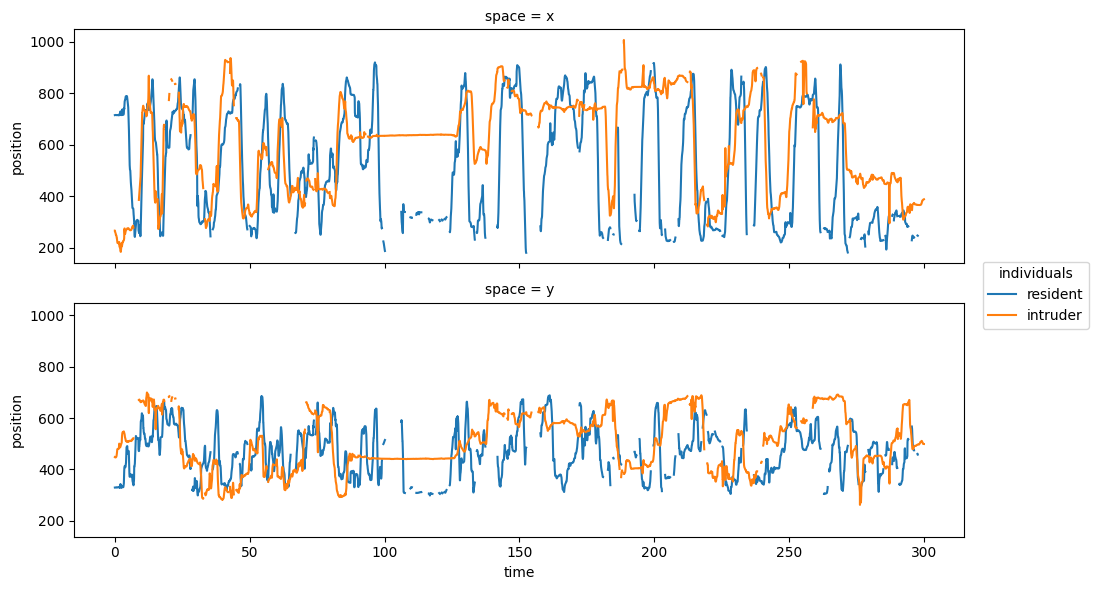

In [17]:
tail_base.plot.line(x="time", hue="individuals", row="space", aspect=3, size=3)
plt.show()

We define the distance between the two individuals as the magnitude of the difference between the tail base positions of the two individuals.

In [18]:
resident_tail_base = tail_base.sel(individuals="resident", drop=True)
intruder_tail_base = tail_base.sel(individuals="intruder", drop=True)
distance = magnitude(resident_tail_base - intruder_tail_base)
distance.name = "Distance (pixels)"
distance

<xarray.DataArray 'Distance (pixels)' (time: 15001)> Size: 120kB
464.5 464.5 464.5 467.2 468.2 469.0 470.3 470.6 ... nan nan nan nan nan nan nan
Coordinates:
  * time     (time) float64 120kB 0.0 0.02 0.04 0.06 ... 299.9 300.0 300.0 300.0

Let's visualise the distance between the two individuals as a histogram.

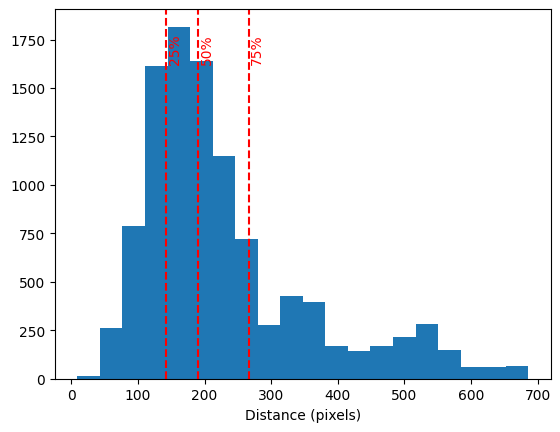

In [19]:
plot_histogram_with_percentiles(
    distance,
    percentiles=[25, 50, 75],
    xlabel="Distance (pixels)",
    n_bins=20,
    density=False,
    # Ucomment the line below to save the plot (instead of displaying it)
    # save_path=plots_folder / f"{pair_name}_inter-individual_distance_histogram.png",
)

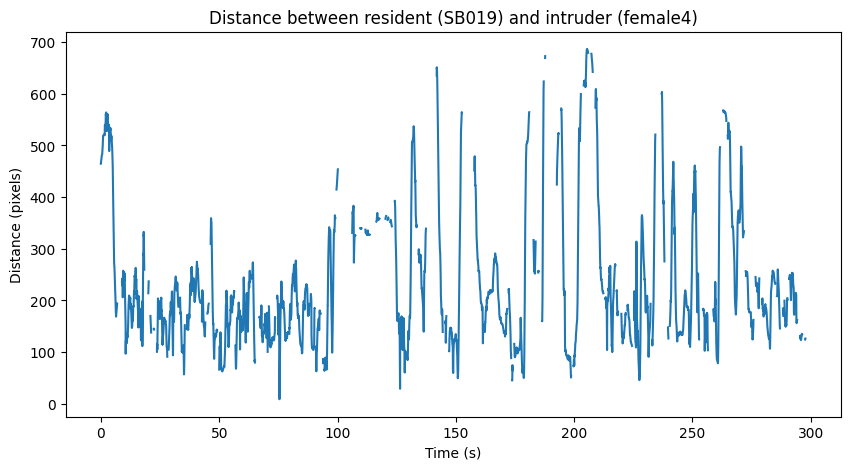

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
distance.plot.line(x="time", ax=ax)
ax.set_title(f"Distance between resident ({resident_id}) and intruder ({intruder_id})")
ax.set_xlabel("Time (s)")
# Uncomment the line below to save the plot
# plt.savefig(plots_folder / f"{pair_name}_inter-individual_distance_timeseries.png")
plt.show()

## Compute speed of each individual
We compute the speed as the magnitude of the "butt" (tail base) keypoint's velocity.

In [21]:
velocity = compute_velocity(tail_base)
speed = magnitude(velocity)
speed.name = "speed (pixels/s)"
speed

<xarray.DataArray 'speed (pixels/s)' (time: 15001, individuals: 2)> Size: 240kB
0.0 0.0 0.0 0.0 5.326 68.46 6.342 103.3 ... nan 25.33 nan 7.639 nan 0.0 nan 0.0
Coordinates:
  * time         (time) float64 120kB 0.0 0.02 0.04 0.06 ... 300.0 300.0 300.0
  * individuals  (individuals) <U8 64B 'resident' 'intruder'

Let's plot the speed of each individual over time.

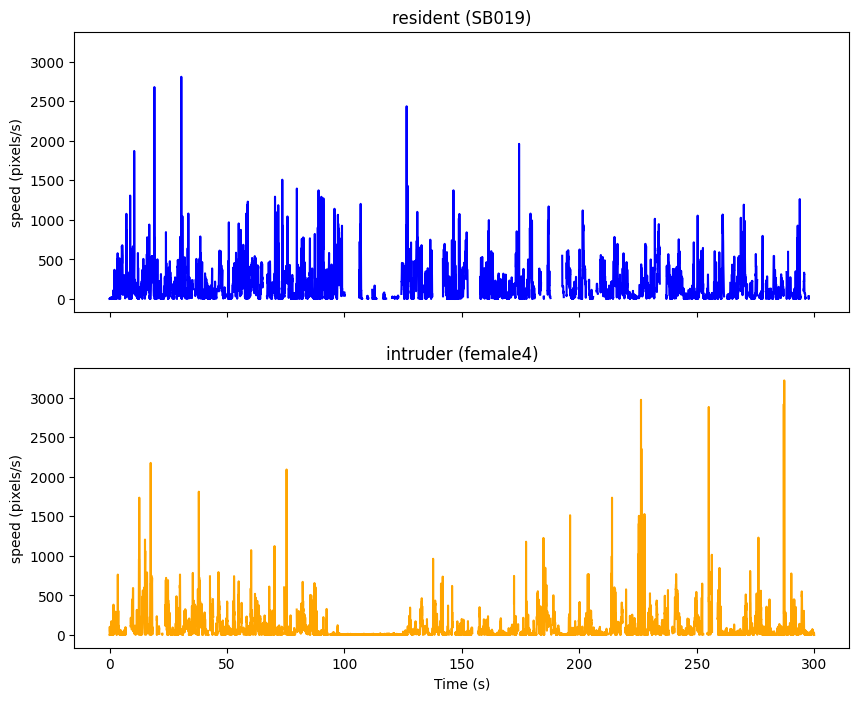

In [22]:
colors = ["blue", "orange"]

fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True) # 2 rows, 1 column
for i, individual_name in enumerate(speed.individuals.values):
    speed.sel(individuals=individual_name).plot.line(x="time", ax=ax[i], color=colors[i])
    ax[i].set_title(f"{individual_name} ({pair_name.split('_')[i]})")
ax[0].set_xlabel("")
ax[1].set_xlabel("Time (s)")
plt.show()
# Uncomment the line below to save the plot
#plt.savefig(plots_folder / f"{pair_name}_speed.png")

Let's plot a histogram of the speed of each individual.

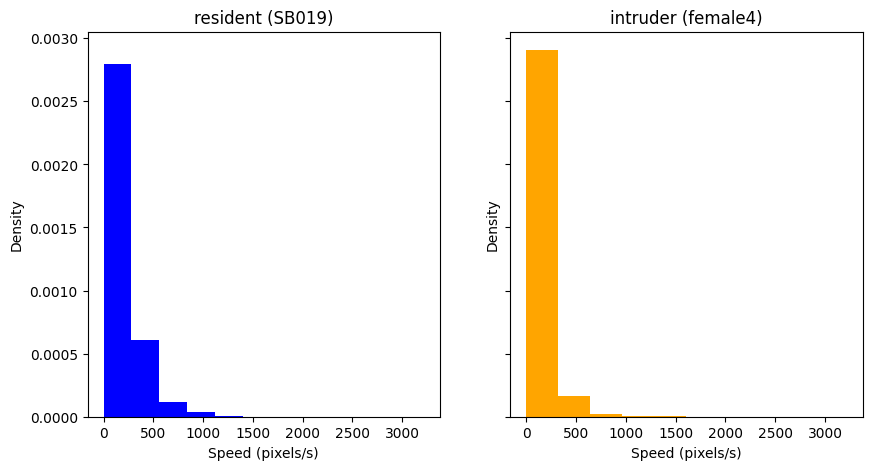

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
for i, individual_name in enumerate(speed.individuals.values):
    speed.sel(individuals=individual_name).plot.hist(
        ax=ax[i], bins=10, color=colors[i], label=individual_name, density=True
    )
    ax[i].set_xlabel("Speed (pixels/s)")
    ax[i].set_ylabel("Density")
    ax[i].set_title(f"{individual_name} ({pair_name.split('_')[i]})")

# Uncomment the line below to save the plot
# plt.savefig(plots_folder / f"{pair_name}_speed_histogram.png")
plt.show()